In [6]:
import pandas as pd
import numpy as np
import spacy
import utility.text_normalizer as tn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import tqdm

In [2]:
def print_scores(model, y_true, X_val):
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')


nlp = spacy.load('en_core_web_md')
train = pd.read_parquet('data/selftrain_data.gzip')
test = pd.read_parquet('data/test_initial.gzip')

In [7]:
def tweet_vector(nlp, tweet):
    tweet = tn.tweet_preprocessor2(tweet)
    tweet = nlp(tweet)
    return tweet.vector


def tweets2vector(nlp, tweets):
    vectors = []
    for tweet in tqdm.tqdm(tweets):
        vectors.append(tweet_vector(nlp, tweet))
    return np.array(vectors)

In [4]:
X_train = tweets2vector(nlp, train['text'])
X_test = tweets2vector(nlp, test['text'])

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [5]:
y_train = train['tag']
y_test = test['tag']

## Manual hyperparameter tuning

In [78]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=17, min_samples_leaf=15, n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=17,
                       min_samples_leaf=15, n_jobs=-1)

              precision    recall  f1-score   support

  irrelevant       0.95      0.86      0.90       452
    relevant       0.75      0.91      0.82       208

    accuracy                           0.88       660
   macro avg       0.85      0.88      0.86       660
weighted avg       0.89      0.88      0.88       660



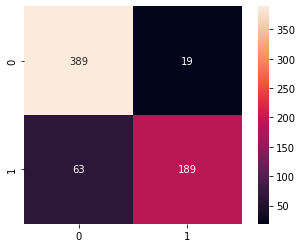

In [79]:
# n_estimators = 50
print_scores(rf, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.95      0.87      0.91       452
    relevant       0.77      0.91      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.89      0.88      0.89       660



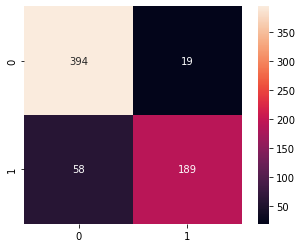

In [33]:
# Min sample leafs = 5
print_scores(rf, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.92      0.92      0.92       452
    relevant       0.83      0.82      0.83       208

    accuracy                           0.89       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.89      0.89      0.89       660



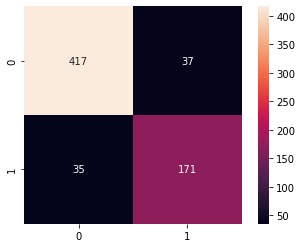

In [29]:
# Min Sample leafs = 1
print_scores(rf, y_test, X_test)

In [35]:
rf1 = RandomForestClassifier(n_jobs=-1, verbose=1, n_estimators=50)
params = {
    'class_weight': ['balanced', None],
    'min_samples_leaf': [1, 5, 10, 15, 20]
}
search = GridSearchCV(rf1, param_grid=params, cv=3, n_jobs=-1, verbose=3, scoring='f1')
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  34 tasks     

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'min_samples_leaf': [1, 5, 10, 15, 20]},
             scoring='f1', verbose=3)

In [37]:
search.best_score_

0.7512154000778682

In [39]:
rf2 = search.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.95      0.86      0.90       452
    relevant       0.74      0.91      0.82       208

    accuracy                           0.87       660
   macro avg       0.85      0.88      0.86       660
weighted avg       0.89      0.87      0.88       660



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


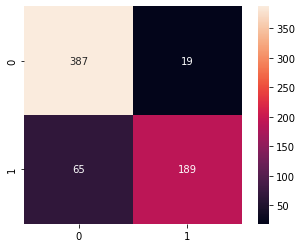

In [42]:
print_scores(rf2, y_test, X_test)

In [49]:
rf2.set_params(n_estimators=150)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=150, n_jobs=-1, verbose=1)

In [50]:
rf2.get_params()

[CV 1/3] END class_weight=balanced, min_samples_leaf=5;, score=0.903 total time=  33.8s
[CV 3/3] END class_weight=balanced, min_samples_leaf=15;, score=0.729 total time=  29.8s
[CV 3/3] END class_weight=None, min_samples_leaf=5;, score=0.740 total time=  33.3s
[CV 3/3] END class_weight=None, min_samples_leaf=15;, score=0.736 total time=  23.9s
[CV 2/3] END class_weight=balanced, min_samples_leaf=10;, score=0.828 total time=  35.7s
[CV 3/3] END class_weight=balanced, min_samples_leaf=10;, score=0.587 total time=  33.4s
[CV 2/3] END class_weight=None, min_samples_leaf=5;, score=0.786 total time=  35.1s
[CV 3/3] END class_weight=None, min_samples_leaf=15;, score=0.532 total time=  24.1s


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 1,
 'warm_start': False}

In [51]:
rf2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   18.7s finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=150, n_jobs=-1, verbose=1)

              precision    recall  f1-score   support

  irrelevant       0.96      0.87      0.91       452
    relevant       0.76      0.92      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.90      0.88      0.88       660



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


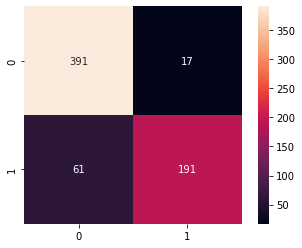

In [52]:
print_scores(rf2, y_test, X_test)

## More granular search around 10 min samples leafs

In [84]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1, n_estimators=100, class_weight='balanced')
params = {
    'min_samples_leaf': [7, 8, 9, 10, 11, 12]
}
search = GridSearchCV(rf, param_grid=params, scoring='f1', n_jobs=-1, verbose=1, cv=3)
search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  34 tasks     

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, verbose=1),
             n_jobs=-1, param_grid={'min_samples_leaf': [7, 8, 9, 10, 11, 12]},
             scoring='f1', verbose=1)

In [85]:
rf3 = search.best_estimator_
rf3, search.best_score_

(RandomForestClassifier(class_weight='balanced', min_samples_leaf=10, n_jobs=-1,
                        verbose=1),
 0.7571126108161685)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

  irrelevant       0.96      0.87      0.91       452
    relevant       0.76      0.92      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.90      0.88      0.89       660



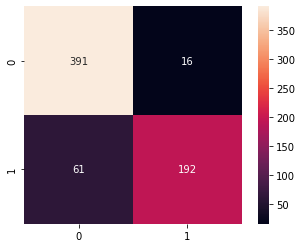

In [86]:
print_scores(rf3, y_test, X_test)

In [119]:
# min_sample_split=20 got 89% acc
rf3.set_params(min_samples_split=17, n_estimators=100, verbose=0)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       min_samples_split=17, n_jobs=-1)

In [120]:
rf3.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       min_samples_split=17, n_jobs=-1)

              precision    recall  f1-score   support

  irrelevant       0.96      0.86      0.91       452
    relevant       0.76      0.92      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.90      0.88      0.88       660



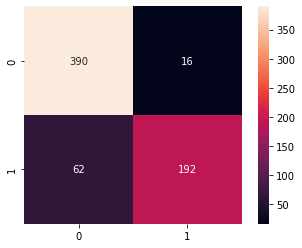

In [121]:
print_scores(rf3, y_test, X_test)

Save model

In [122]:
# import joblib
# joblib.dump(rf3, '../../../models/rf_83.pkl')

['../../../models/rf_83.pkl']